# Lecture III: Recurrent Neural Network
This homework aims to help you understand Recurrent Neural Network by building a RNN classifier on Japanese Vowels from different male speakers. 

As usual, we will first import some useful modules:

In [1]:
# pylint: disable=E1101,R,C
import numpy as np
import os
import argparse
import time
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import gzip
import pickle
from scipy import sparse
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast 
torch.set_default_tensor_type(torch.FloatTensor)

The Japanese Vowel dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels). For a detailed description, please look at this website. First, we will download the dataset:



## Part I: Dataset

First, we will need to prepare the dataset using `Dataset()` class. Since in last home work, I have gone through the detail of this class, I will skip most of the technical details.

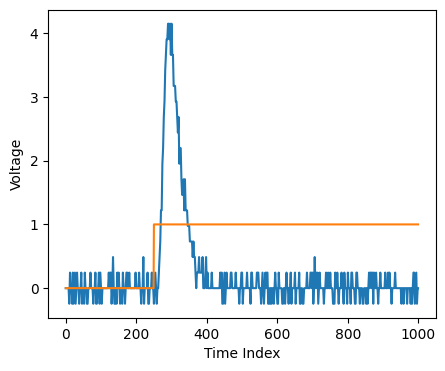

In [25]:
class Wave_forms(Dataset):

    def __init__(self,plot=True):
        
        # Load the waveforms with the truth
        
        waveforms = np.load('Data/data.npy')
        times = np.load('Data/labels.npy')
       
       
        waveforms_train =[] 
        waveforms_test =  []
        times_train =[] 
        times_test = []
        
        for i in range(len(waveforms)):
            if i < int(0.7*len(waveforms)):
                waveforms_train.append(waveforms[i])
                times_train.append(times[i])
                
            else:
                waveforms_test.append(waveforms[i])
                times_test.append(times[i])
               
                
        self.train_test_split = len(waveforms_train)

        self.data = waveforms_train+waveforms_test
        self.labels = times_train+times_test
        self.size = len(waveforms_train)+len(waveforms_test)
        

        
        if plot:
            self.plot_data()
        
    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size
        
    def __getitem__(self, idx):
        return self.data[idx].astype(float), self.labels[idx].astype(float)

    
    
    def get_train_test_split(self):
        '''
        This function get the train test split size of the dataset
        '''
        return self.train_test_split
    
    
    
    def plot_data(self):
    
        plt.figure(figsize=(5,4))
        num = 1
        sample_index = np.random.randint(low=0, high=self.__len__(), size=num)
        voices = []
        for i in range(num):
            voice, label = self.__getitem__(sample_index[i])
            #print(label)
            y2 = [j[0] for j in label]
            y = [j[0] for j in voice]
            plt.plot(np.arange(len(y)), y)
            plt.plot(np.arange(len(y2)), y2)
            
        plt.xlabel("Time Index")
        plt.ylabel("Voltage")
        plt.show()
        
Wave_forms()

## Part II: Recurrent Neural Network
In this part, we will buid an LSTM based recurrent neural network model to analyze the input LPC spectrum. Since this is the second time we build a NN, I will leave most of the work to you. Some useful resources include:
- [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm)
- [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)
- [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html?highlight=leakyrelu#torch.nn.LeakyReLU)
- [nn.Sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential)

Some useful tips for building the recurrent neural network:
- Read [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) carefully, make sure you understand the input and output shape of the LSTM layer. The [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) layer outputs `output, (h_n, c_n)`:
    -  `output` has a shape of `(Seq_len,Batch_size,num_direction*hidden_size)`, it contains all intermediate hidden state outputs of the last layer. Note that there is a `batch_first` flag in LSTM input which may change the output shape to `(Batch_size,Seq_len,num_direction*hidden_size)`. If you want to select only the last hidden state, you shoud simply index the `Seq_len` dimension.
    -  `(h_n, c_n)` contains the last hidden state outputs of each layers
- Remember that you want to select only the the **last hidden state output**. You can either extract it from `output` or `h_n`.
- Then you will feed the **last hidden state output** into `self.fc_classifier`. You will need to adjust the `hidden_size` of LSTM output and the input size of first fully connected layer in `self.fc_classifier` to match
- Make sure the output of RNN model has the shape of [BATCHSIZE,9], since we have 9 speakers in the dataset we'd like to classify into

In [4]:
'''
This script contains the PositionalUNet network along with 3 candidate discriminators:
* RNN+Attention discriminator
* CNN+PositionalEncoding Discriminator
* Fully Connected Discriminators
we have tested all 3 discriminators, turns out that the RNN+Attention works the best
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import math



class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=11, padding=5,bias=False),
            nn.BatchNorm1d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(mid_channels, out_channels, kernel_size=7, padding=3,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels, pool=True):
        super().__init__()
        self.pool = pool
        self.pool_layer = nn.MaxPool1d(2)
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        if self.pool:
            x = self.pool_layer(x)
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=3, mode='linear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose1d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]

        x1 = F.pad(x1, [diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        mid_channels = int(in_channels + out_channels)//2
        self.conv = nn.Sequential(
            torch.nn.Conv1d(in_channels, mid_channels, kernel_size=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(mid_channels, out_channels, kernel_size=1),
             )
    # @torchsnooper.snoop()
    def forward(self, x):
        return self.conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.bilinear = True
        
        multi = 40
        
        self.inc = DoubleConv(1, multi) #1 instead of 12 for feeding 1 wave form at a time --> input channels 
        self.down1 = Down(multi, multi*2)
        self.down2 = Down(multi*2, multi*4)
        self.down3 = Down(multi*4, multi*8)
        factor = 2 if self.bilinear else 1
        self.down4 = Down(multi*8, multi*16 // factor,pool=False)
        
       
        
        self.up1 = Up(multi*16, multi*8 // factor, self.bilinear)
        self.up2 = Up(multi*8, multi*4 // factor, self.bilinear)
        self.up3 = Up(multi*4, multi*2 // factor, self.bilinear)
        self.up4 = Up(multi*2, multi // factor, self.bilinear)
        self.outc = OutConv(multi // factor, 2) # This 2 is number of decisions we want it to make. In the vowel case we only want 2 decisions (0/non0), in waveform case we may need more
        self.softmax = torch.nn.Softmax(dim=-1)
        #self.sigmoid = torch.Sigmoid()
    
    # @torchsnooper.snoop()
    def forward(self, x):
        x = x.transpose(1,2)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        
        #Two inputs in the next ones because of the contraction paths 
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        
        output = output.transpose(1,2)
        # output = self.softmax(output)  
        output = torch.sigmoid(output)
        
        return output


Similar to what we did in Lecture 2 homework, we will pull out 1 event from the dataset, and use `torchsnooper.snoop()` to check the network structure. Before proceeding to the next part, you may want to stare at the tensor output of `torchsnooper.snoop()` carefully to understand how the data is flowing within the RNN network.

In [6]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(Wave_forms(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
test_network = UNet()
#print(type(test_event)) (torch.tensor)
print(test_network(test_event))

tensor([[[0.5264, 0.5418],
         [0.4944, 0.5725],
         [0.4788, 0.5517],
         ...,
         [0.4926, 0.5107],
         [0.4899, 0.5236],
         [0.4852, 0.4712]]], grad_fn=<SigmoidBackward0>)


## Part III: Training
After building the neural network, we train it the same way as we did in Lecture 2:

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS =10
LEARNING_RATE =1e-3 # 1e-2 is a good learning rate for general purpose
BATCH_SIZE=5

In [8]:
def set_up_classifier():
    classifier = UNet() # Define CNN neural network classifier
    classifier.to(DEVICE)     # Send the classifier to DEVICE as we defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = torch.nn.BCELoss()
    criterion = criterion.to(DEVICE)

    #Define the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(),lr=LEARNING_RATE)
    
    return classifier, criterion, optimizer

In [9]:
def get_dataloader():
    dataset = Wave_forms(plot=False)
    #Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] is the training dataset, indices [train_test_split, len(dataset)] is the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    #Shuffle the two indices list
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    #print(val_indices)
    # Define two subset random sampler to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    #print(train_sampler)
    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisibe by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)
    
    return train_loader, test_loader

In [10]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()


loss_values = []
accuracy_values = []
y_true = []
y_pred = []
        
for epoch in range(NUM_EPOCHS):
    for i, (utterances, labels) in tqdm(enumerate(train_loader)):

        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.
        
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE).float()

        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
    
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE)

        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
        
  

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())
    
 

# of params in model:  7008575


420it [01:43,  4.04it/s]


Epoch [1/10], Iter [420/420] Loss: 0.0096

420it [01:45,  3.97it/s]


Epoch [2/10], Iter [420/420] Loss: 0.0072

420it [01:47,  3.91it/s]


Epoch [3/10], Iter [420/420] Loss: 0.0023

420it [01:46,  3.93it/s]


Epoch [4/10], Iter [420/420] Loss: 0.0060

420it [01:49,  3.84it/s]


Epoch [5/10], Iter [420/420] Loss: 0.0044

420it [01:41,  4.12it/s]


Epoch [6/10], Iter [420/420] Loss: 0.0032

420it [01:42,  4.10it/s]


Epoch [7/10], Iter [420/420] Loss: 0.0052

420it [01:41,  4.13it/s]


Epoch [8/10], Iter [420/420] Loss: 0.0035

420it [01:39,  4.22it/s]


Epoch [9/10], Iter [420/420] Loss: 0.0047

420it [01:40,  4.19it/s]

Epoch [10/10], Iter [420/420] Loss: 0.0065

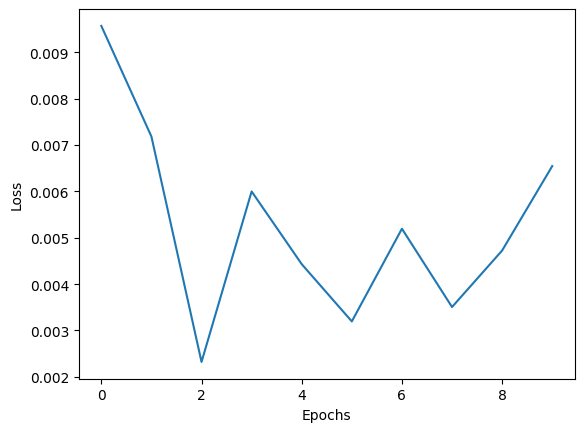

In [11]:

# plot the loss values
plt.plot(range(len(loss_values)), loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

tensor([[[0.2689, 0.7311],
         [0.2689, 0.7311],
         [0.2689, 0.7311],
         ...,
         [0.7311, 0.2689],
         [0.7311, 0.2689],
         [0.7311, 0.2689]]], grad_fn=<SoftmaxBackward0>)


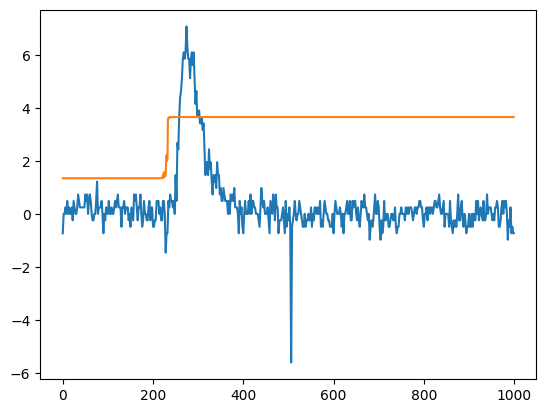

In [12]:
test_event, test_label = Wave_forms(plot=False).__getitem__(10)
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
test_network = classifier
test_network.eval()
decision = torch.softmax(test_network(test_event),dim=-1)
print(decision)
test_event = test_event.detach().numpy()
decision = decision.detach().numpy()
plt.plot(test_event[0,:,:])

plt.plot([j[0]*5 for j in decision[0]])
#plt.plot([(j[2]-0.212)*55 for j in decision[0]])

#print([j[2]*5 for j in decision])
#print(np.shape([j for j in decision]))
#plt.show()

In [13]:
#to find charge:
waveforms = []
step_size= 0.244
charge = np.sum(waveform) * step_size

NameError: name 'waveform' is not defined

In [14]:
charge = np.trapz(waveform, dx=step_size)

NameError: name 'waveform' is not defined

In [68]:
#Add MSE loss for finding amplitude
x=np.load('Data/Voltages.npy')
print(x)
print(type(x))

[[[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [7.29109200e-08]
   [7.18281448e-08]
   [7.07623312e-08]]]


 [[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [7.23075914e-08]
   [7.12408937e-08]
   [7.01907935e-08]]]


 [[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [4.77080504e-08]
   [4.70315549e-08]
   [4.63651723e-08]]]


 ...


 [[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [1.76892116e-07]
   [1.74154910e-07]
   [1.71462404e-07]]]


 [[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [6.34654898e-07]
   [6.24399362e-07]
   [6.14318814e-07]]]


 [[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [2.45033195e-08]
   [2.41636044e-08]
   [2.38288533e-08]]]]
<class 'numpy.ndarray'>


[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

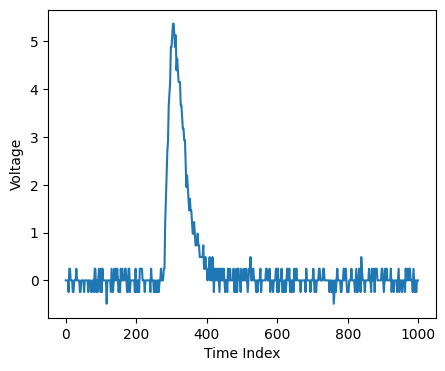

In [69]:
class Wave_forms(Dataset):

    def __init__(self,plot=True):
        
        # Load the waveforms with the truth
        
        waveforms = np.load('Data/data.npy')
        amp = np.load('Data/Voltages.npy')
        waveforms_train =[] 
        waveforms_test =  []
        amp_train =[] 
        amp_test = []
        
        for i in range(len(waveforms)):
            if i < int(0.7*len(waveforms)):
                waveforms_train.append(waveforms[i])
                amp_train.append(amp[i])
            else:
                waveforms_test.append(waveforms[i])
                amp_test.append(amp[i])
                
        self.train_test_split = len(waveforms_train)

        self.data = waveforms_train+waveforms_test
        self.labels = amp_train+amp_test
        self.size = len(waveforms_train)+len(waveforms_test)
        

        
        if plot:
            self.plot_data()
        
    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size
        
    def __getitem__(self, idx):
        return self.data[idx].astype(float), self.labels[idx].astype(float)

    
    
    def get_train_test_split(self):
        '''
        This function get the train test split size of the dataset
        '''
        return self.train_test_split
    
    
    
    def plot_data(self):
    
        plt.figure(figsize=(5,4))
        num = 1
        sample_index = np.random.randint(low=0, high=self.__len__(), size=num)
        voices = []
        for i in range(num):
            voice, label = self.__getitem__(sample_index[i])
            #print(label)
            y2 = [j[0] for j in label]
            y = [j[0] for j in voice]
            plt.plot(np.arange(len(y)), y)
            plt.plot(np.arange(len(y2)), y2)
        
        print(label[0])   
        plt.xlabel("Time Index")
        plt.ylabel("Voltage")
        plt.show()
        
Wave_forms()


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import math



class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=11, padding=5,bias=False),
            nn.BatchNorm1d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(mid_channels, out_channels, kernel_size=7, padding=3,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels, pool=True):
        super().__init__()
        self.pool = pool
        self.pool_layer = nn.MaxPool1d(2)
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        if self.pool:
            x = self.pool_layer(x)
        return self.maxpool_conv(x)

In [71]:
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=3, mode='linear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose1d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]

        x1 = F.pad(x1, [diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        mid_channels = int(in_channels + out_channels)//2
        self.conv = nn.Sequential(
            torch.nn.Conv1d(in_channels, mid_channels, kernel_size=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(mid_channels, out_channels, kernel_size=1),
             )
    # @torchsnooper.snoop()
    def forward(self, x):
        return self.conv(x)

In [72]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.bilinear = True
        
        multi = 40
        
        self.inc = DoubleConv(1, multi) #1 instead of 12 for feeding 1 wave form at a time --> input channels 
        self.down1 = Down(multi, multi*2)
        self.down2 = Down(multi*2, multi*4)
        self.down3 = Down(multi*4, multi*8)
        factor = 2 if self.bilinear else 1
        self.down4 = Down(multi*8, multi*16 // factor,pool=False)
        
       
        
        self.up1 = Up(multi*16, multi*8 // factor, self.bilinear)
        self.up2 = Up(multi*8, multi*4 // factor, self.bilinear)
        self.up3 = Up(multi*4, multi*2 // factor, self.bilinear)
        self.up4 = Up(multi*2, multi // factor, self.bilinear)
        self.outc = OutConv(multi // factor, 1) # This 2 is number of decisions we want it to make. In the vowel case we only want 2 decisions (0/non0), in waveform case we may need more
        #self.softmax = torch.nn.Softmax(dim=-1)
        self.sigmoid = torch.nn.Sigmoid()
    
    # @torchsnooper.snoop()
    def forward(self, x):
        x = x.transpose(1,2)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        
        #Two inputs in the next ones because of the contraction paths 
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        
        output = output.transpose(1,2)
        #output = self.softmax(output) #ask Aobo which one 
        #output = torch.sigmoid(output)
        
        return output


In [73]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(Wave_forms(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
test_network = UNet()
#print(type(test_event)) (torch.tensor)
print(test_network(test_event))

tensor([[[ 7.8171e-02],
         [ 2.4310e-01],
         [ 3.1555e-01],
         [ 4.1228e-02],
         [-6.8673e-03],
         [ 7.3734e-02],
         [ 1.6023e-01],
         [ 7.5075e-02],
         [ 2.2122e-02],
         [ 1.2692e-02],
         [ 5.7916e-02],
         [ 9.3444e-02],
         [ 9.8716e-02],
         [ 1.0577e-01],
         [ 7.6417e-02],
         [ 1.2291e-01],
         [ 1.7870e-01],
         [ 1.5147e-01],
         [ 1.3338e-01],
         [ 1.0727e-01],
         [ 1.0235e-01],
         [-6.3110e-02],
         [ 2.8324e-02],
         [ 8.5880e-02],
         [ 5.9648e-02],
         [ 6.3439e-02],
         [-1.7211e-02],
         [ 4.9615e-02],
         [ 7.5518e-02],
         [ 3.1033e-02],
         [ 5.9761e-02],
         [ 9.9834e-02],
         [ 4.8164e-02],
         [ 8.5853e-02],
         [ 7.3769e-02],
         [ 5.6370e-02],
         [ 1.8771e-02],
         [-1.3188e-02],
         [ 6.7700e-02],
         [ 8.5332e-02],
         [ 5.4852e-02],
         [ 2.584

In [74]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS =10
LEARNING_RATE =1e-3 # 1e-2 is a good learning rate for general purpose
BATCH_SIZE=5

In [75]:
def set_up_classifier():
    classifier = UNet() # Define CNN neural network classifier
    classifier.to(DEVICE)     # Send the classifier to DEVICE as we defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = torch.nn.MSELoss()
    criterion = criterion.to(DEVICE)

    #Define the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(),lr=LEARNING_RATE)
    
    return classifier, criterion, optimizer

In [76]:
def get_dataloader():
    dataset = Wave_forms(plot=False)
    #Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] is the training dataset, indices [train_test_split, len(dataset)] is the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    #Shuffle the two indices list
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    #print(val_indices)
    # Define two subset random sampler to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    #print(train_sampler)
    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisibe by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)
    
    return train_loader, test_loader

In [77]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()


loss_values = []
accuracy_values = []
y_true = []
y_pred = []
        
for epoch in range(NUM_EPOCHS):
    for i, (utterances, labels) in tqdm(enumerate(train_loader)):

        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.
        
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE).float()

        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
    
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE)

        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
        
  

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())
    
 





# of params in model:  7008541


420it [01:36,  4.33it/s]


Epoch [1/10], Iter [420/420] Loss: 0.4107

420it [01:37,  4.31it/s]


Epoch [2/10], Iter [420/420] Loss: 0.6884

330it [01:16,  4.29it/s]
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([[[0.5045],
         [0.5052],
         [0.5058],
         [0.5055],
         [0.5059],
         [0.5061],
         [0.5060],
         [0.5059],
         [0.5058],
         [0.5056],
         [0.5054],
         [0.5052],
         [0.5052],
         [0.5052],
         [0.5052],
         [0.5052],
         [0.5053],
         [0.5053],
         [0.5053],
         [0.5052],
         [0.5052],
         [0.5051],
         [0.5050],
         [0.5050],
         [0.5050],
         [0.5051],
         [0.5050],
         [0.5049],
         [0.5048],
         [0.5047],
         [0.5046],
         [0.5045],
         [0.5044],
         [0.5041],
         [0.5039],
         [0.5038],
         [0.5038],
         [0.5037],
         [0.5038],
         [0.5038],
         [0.5038],
         [0.5038],
         [0.5039],
         [0.5040],
         [0.5041],
         [0.5042],
         [0.5042],
         [0.5042],
         [0.5042],
         [0.5042],
         [0.5041],
         [0.5042],
         [0.

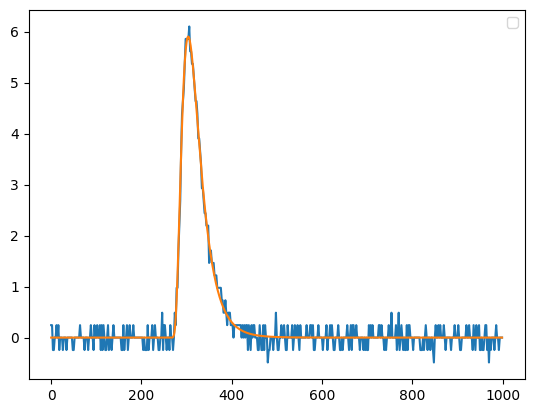

In [79]:
test_event, test_label = Wave_forms(plot=False).__getitem__(10)
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
test_network = classifier
test_network.eval()
decision = torch.sigmoid(test_network(test_event))
print(decision)
test_event = test_event.detach().numpy()
decision = decision.detach().numpy()
plt.plot(test_event[0,:,:])


plt.plot(test_label[0,:,:])
plt.legend()
plt.show()